In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
dset_path = './norm_counts_AML.txt'
anno_path = './annotation_AML.txt'
gene_path = './L1000_landmark_gene_list.txt'

## Load data

In [3]:
# Warning: data look as follows, which is different from the common form in ML (#samples, #feats).
#               sample1 sample2 ...
#  gene_name1
#  gene_name2
#  ...
# Thefore I first remove the first column and row and then transpose the whole matrix.

dset = pd.read_csv(dset_path, sep='\t', header=0, index_col=0)
dset = dset.T

In [4]:
# Somehow, the annotation file cannot be read by pandas
#anno = pd.read_csv(anno_path)
anno = []
classes = ['ALL','AML','CLL','CML']
with open(anno_path) as f:
    # Discard the header manually.
    f.readline()
    
    # Each line consists of Dataset, GSE, Condition, Disease, Tissue, FAB, and Filename
    for line in f.readlines():
        line = line.strip()
        label = line.split('\t')[-4]  # Get the Disease label
        if label not in classes:
            label = 'Other'
        anno.append(label)
        

### Map strings to integers
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(anno)
label_map = label_encoder.classes_
label_dict = {}
for ind, ll in enumerate(label_map):
    label_dict[ll] = ind

    
# Check whether both the dataset and labels have the same ammount of samples
print(f'dset shape: {dset.shape}')
print(f'labels shape: {labels.shape}')
assert dset.shape[0] == labels.shape[0]

print(label_dict['AML'])
# print((labels == label_dict['healthy']))
print(np.max(labels))
print(label_dict)


### load gene
gene = []
with open(gene_path) as f:
    # Discard the header manually.
    f.readline()    
    for line in f.readlines():
        line = line.strip()
        gene.append(line)

dset shape: (1181, 12688)
labels shape: (1181,)
1
4
{'ALL': 0, 'AML': 1, 'CLL': 2, 'CML': 3, 'Other': 4}


In [5]:
print(dset.shape)

(1181, 12688)


In [6]:
### extract the genes that are in the list
gene = set(gene)
print(len(gene))
extract_dset = []
for g in dset.columns:
    if g in gene:
        extract_dset.append(dset[g])
extract_dset = np.array(extract_dset).T

978


## Standarize

In [7]:
### standarize dataset
# dset=dset.values
# mean = np.mean(dset, axis=0, keepdims=True)  # should take over axis=0
# std = np.std(dset, axis=0, keepdims=True)
# dset_ = (dset - mean) / std

dset_standard = StandardScaler().fit_transform(dset)
dset_minmax = MinMaxScaler().fit_transform(dset)

extract_standard = StandardScaler().fit_transform(extract_dset)
extract_minmax = MinMaxScaler().fit_transform(extract_dset)

## PCA

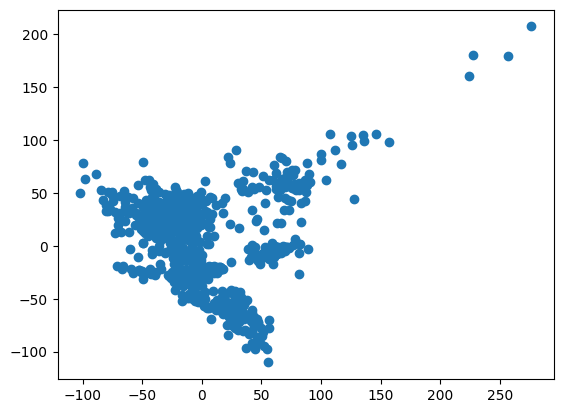

In [8]:
# All_points
pca = PCA(n_components=2)
dset_pca = pca.fit(dset_standard).transform(dset_standard)
plt.figure()
plt.scatter(dset_pca[:, 0], dset_pca[:, 1])

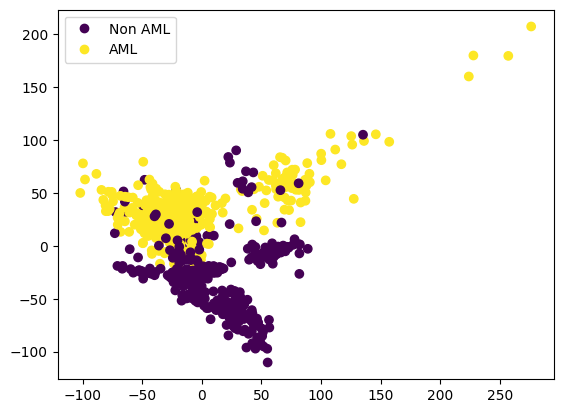

In [9]:
# Extract 'Non AML' and 'AML'
extract_dset = dset_standard[(labels != label_dict['AML']) | (labels == label_dict['AML'])]
extract_label = labels[(labels != label_dict['AML']) | (labels == label_dict['AML'])]
extract_label[np.where(extract_label != 1)] = 0

# dset_r = pca.fit(extract_dset).transform(extract_dset)
dset_r = pca.fit(dset_standard).transform(extract_dset)


plt.figure()
scatter = plt.scatter(dset_r[:, 0], dset_r[:, 1], c=extract_label)

unique_labels = ["Non AML", "AML"]
handles = [plt.Line2D([], [], marker='o', linestyle='', color=scatter.cmap(scatter.norm(i)), label=label) 
           for i, label in enumerate(unique_labels)]
plt.legend(handles=handles)

# extract_label

In [10]:
label_dict

{'ALL': 0, 'AML': 1, 'CLL': 2, 'CML': 3, 'Other': 4}

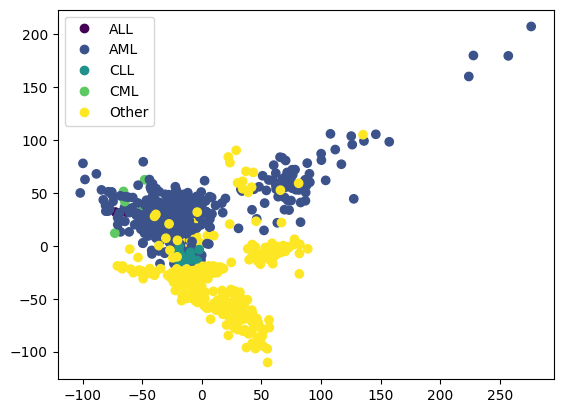

In [11]:
# Extract 'Non AML' and 'AML'
# extract_dset = dset_standard[(labels != label_dict['AML']) | (labels == label_dict['AML'])]
# extract_label = labels[(labels != label_dict['AML']) | (labels == label_dict['AML'])]
# extract_label[np.where(extract_label != 1)] = 0

# dset_r = pca.fit(extract_dset).transform(extract_dset)
dset_r = pca.fit(dset_standard).transform(dset_standard)


plt.figure()
scatter = plt.scatter(dset_r[:, 0], dset_r[:, 1], c=labels)

unique_labels = np.unique(labels)
unique_labels = list(label_dict.keys())

handles = [plt.Line2D([], [], marker='o', linestyle='', color=scatter.cmap(scatter.norm(i)), label=label) 
           for i, label in enumerate(unique_labels)]
plt.legend(handles=handles)

# extract_label

## Linear SVM

In [12]:
def eval_svm(dset, labels, test_fraction, k, train_on='Train'):
    Train_x, Test_x, Train_y, Test_y = train_test_split(dset, labels, test_size=test_fraction,
                                                        random_state=k)

    if train_on == 'Train':
        train_x,train_y,test_x,test_y = Train_x, Train_y, Test_x, Test_y
    else:
        train_x,train_y,test_x,test_y = Test_x, Test_y, Train_x, Train_y
        
    ## l1
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(train_x, train_y)
    model=lsvc
    print(f"LinearSVC l1: {'test' if train_on == 'Train' else 'train'} acc", model.score(test_x,test_y))
    model = SelectFromModel(lsvc, prefit=True)
    x_new = model.transform(dset)
    print(dset.shape)
    print(x_new.shape)


    ## l2
    lsvc = LinearSVC(penalty="l2").fit(train_x, train_y)
    model=lsvc
    print(f"LinearSVC l2: {'test' if train_on == 'Train' else 'train'} acc", model.score(test_x,test_y))
    model = SelectFromModel(lsvc, prefit=True)
    x_new = model.transform(dset)
    print(dset.shape)
    print(x_new.shape)

    
## Train-test Split  
k=1000
test_fraction = 0.2
### evaluate both pre-processing scheme
print("****Default")
eval_svm(dset, labels, test_fraction, k)
eval_svm(dset, labels, test_fraction, k, 'Test')

print("****Standardize")
eval_svm(extract_standard, labels, test_fraction, k)
eval_svm(extract_standard, labels, test_fraction, k, 'Test')

print("****Minmax")
eval_svm(extract_minmax, labels, test_fraction, k)
eval_svm(extract_minmax, labels, test_fraction, k, 'Test')

****Default
LinearSVC l1: test acc 0.9831223628691983
(1181, 12688)
(1181, 25)
LinearSVC l2: test acc 0.9957805907172996
(1181, 12688)
(1181, 3276)
LinearSVC l1: train acc 0.9597457627118644
(1181, 12688)
(1181, 14)
LinearSVC l2: train acc 0.9597457627118644
(1181, 12688)
(1181, 3194)
****Standardize
LinearSVC l1: test acc 0.9831223628691983
(1181, 958)
(1181, 66)
LinearSVC l2: test acc 0.9873417721518988
(1181, 958)
(1181, 426)
LinearSVC l1: train acc 0.9375
(1181, 958)
(1181, 23)
LinearSVC l2: train acc 0.9417372881355932
(1181, 958)
(1181, 405)
****Minmax
LinearSVC l1: test acc 0.9367088607594937
(1181, 958)
(1181, 8)
LinearSVC l2: test acc 0.9957805907172996
(1181, 958)
(1181, 408)
LinearSVC l1: train acc 0.527542372881356
(1181, 958)
(1181, 1)
LinearSVC l2: train acc 0.9703389830508474
(1181, 958)
(1181, 399)


## Other Classifiers performance

In [13]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBRegressor

In [14]:
def eval_classifiers(Train_x,Train_y,Test_x,Test_y,models,if_binary=True):
    # Number of models
    L = len(models)
    Predict_av = np.zeros([len(Test_y), L]) 

    # k fold cross validation
    num_folds = 1

    # Output Initialization
    AUC_ar   = np.array([[0. for x in range(num_folds)] for y in range(L)]).astype(np.float32)
    AUPRC_ar = np.array([[0. for x in range(num_folds)] for y in range(L)]).astype(np.float32)

    for j in range(L):        

        X_train = Train_x
        Y_train = Train_y
        X_test = Test_x
        Y_test = Test_y
        
        model_name = models[j]            
        print(' Algorithm: ' + model_name)

        if model_name == 'logisticregression':
            model = LogisticRegression()

        if model_name == 'NN':    
            model = MLPClassifier(hidden_layer_sizes=(200,200))

        if model_name == 'randomforest':      
            model = RandomForestClassifier()

        if model_name == 'gaussiannb':  
            model = GaussianNB()

        if model_name == 'bernoullinb':  
            model = BernoulliNB()

        if model_name == 'multinb':  
            model = MultinomialNB()

        if model_name == 'svmlin':         
            model = svm.LinearSVC()

        if model_name == 'gbm':         
            model = GradientBoostingClassifier()    

        if model_name == 'Extra Trees':
            model = ExtraTreesClassifier(n_estimators=20)

        if model_name == 'LDA':
            model = LinearDiscriminantAnalysis() 

        if model_name == 'Passive Aggressive':
            model = PassiveAggressiveClassifier()

        if model_name == 'AdaBoost':
            model = AdaBoostClassifier()

        if model_name == 'Bagging':
            model = BaggingClassifier()

        if model_name == 'xgb':
            model = XGBRegressor()                                    

        if(model_name=='svmlin' or model_name=='Passive Aggressive'): 
            model.fit(X_train, Y_train)
            Predict = model.decision_function(X_test)

        elif (model_name =='xgb'):
            model.fit(np.asarray(X_train), Y_train)
            Predict = model.predict(np.asarray(X_test))

        else:
            model.fit(X_train, Y_train)
            Predict = model.predict(X_test)

        Predict_av[:,j] = Predict
        print(Predict.shape)
        print(np.sum(Y_test==Predict) / len(Y_test))
        
        if if_binary:
            for j in range(L):
                model_name = models[j]            
                AUC_ar[j]= metrics.roc_auc_score(Y_test, Predict_av[:,j])
                AUPRC_ar[j] = metrics.average_precision_score(Y_test, Predict_av[:,j])
                print(' Algorithm: ' + model_name)
                print( '   AUROC: ',np.mean(AUC_ar[j,:]))
                print( '   AUPRC: ',np.mean(AUPRC_ar[j,:]))
            return AUC_ar, AUPRC_ar
        else:
            model_name = models[j]     
            AUC_ar[j] = np.sum(Y_test==Predict_av[:,j]) / len(Y_test) 
    return AUC_ar

In [15]:
k=1000
test_fraction = 0.2

data= extract_dset
Train_x, Test_x, Train_y, Test_y = train_test_split(data, labels, test_size=test_fraction,
                                                    random_state=k)
print(np.unique(Train_y))
print(np.unique(Test_y))

[0 1 2 3 4]
[0 1 2 3 4]


In [16]:
models = ['logisticregression','randomforest', 'gaussiannb','bernoullinb',
'Extra Trees','LDA', 'AdaBoost','Bagging','NN','xgb']

AUC_ar = eval_classifiers(Train_x, Train_y, Test_x, Test_y, models, if_binary=False)

 Algorithm: logisticregression
(237,)
0.9873417721518988
 Algorithm: randomforest
(237,)
0.9873417721518988
 Algorithm: gaussiannb
(237,)
0.9578059071729957
 Algorithm: bernoullinb
(237,)
0.9578059071729957
 Algorithm: Extra Trees
(237,)
0.9915611814345991
 Algorithm: LDA
(237,)
0.9831223628691983
 Algorithm: AdaBoost
(237,)
0.9240506329113924
 Algorithm: Bagging
(237,)
0.9957805907172996
 Algorithm: NN
(237,)
0.9831223628691983
 Algorithm: xgb
(237,)
0.004219409282700422


In [17]:
AUC_ar

array([[0.98734176],
       [0.98734176],
       [0.95780593],
       [0.95780593],
       [0.9915612 ],
       [0.98312235],
       [0.9240506 ],
       [0.9957806 ],
       [0.98312235],
       [0.00421941]], dtype=float32)